In [1]:
from sklearn import preprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据
file_path_train = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\KDDTrain+.txt"
file_path_test = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\KDDTest+.txt"
# 定义列名
data_columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
                "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"]
# 加载数据
train_data = pd.read_csv(file_path_train, header=None, names=data_columns)
test_data = pd.read_csv(file_path_test, header=None, names=data_columns)

attack_mapping = {}
with open(r'D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\attack_name',
          'r') as file:
    for line in file:
        parts = line.strip().split(' ')
        if len(parts) == 2:
            attack, category = parts
            attack_mapping[attack] = category
            
# 然后像之前那样使用这个映射字典
train_data['label'] = train_data['label'].map(attack_mapping)
test_data['label'] = test_data['label'].map(attack_mapping)

# 找出只在训练集中出现的 service 类型
unique_service_train = set(train_data['service']) - set(test_data['service'])
# 删除训练集中存在但测试集中不存在的 service 类型的行
train_data = train_data[~train_data['service'].isin(unique_service_train)]

# 删除train_data中的difficulty, label列
X_train = train_data.drop('label', axis=1)
X_train = X_train.drop('difficulty', axis=1)
# 提取出训练集中的label标签
labels_train = train_data['label']
# 删掉测试集的标签项
X_test = test_data.drop('label', axis=1)
X_test = X_test.drop('difficulty', axis=1)
labels_test = test_data['label']

# 初始化LabelEncoder
le_protocol_type = preprocessing.LabelEncoder()
le_service = preprocessing.LabelEncoder()
le_flag = preprocessing.LabelEncoder()
le_labels = preprocessing.LabelEncoder()

# 对训练集进行标签编码
X_train['protocol_type'] = le_protocol_type.fit_transform(X_train['protocol_type'])
X_train['service'] = le_service.fit_transform(X_train['service'])
X_train['flag'] = le_flag.fit_transform(X_train['flag'])
labels_train = le_labels.fit_transform(labels_train) + 1

# 使用相同的编码器对测试集进行标签编码
X_test['protocol_type'] = le_protocol_type.transform(X_test['protocol_type'])
X_test['service'] = le_service.transform(X_test['service'])
X_test['flag'] = le_flag.transform(X_test['flag'])
labels_test = le_labels.transform(labels_test) + 1

protocol_type_mapping = le_protocol_type.classes_
service_mapping = le_service.classes_
flag_mapping = le_flag.classes_
label_mapping = le_labels.classes_

from imblearn.over_sampling import ADASYN

# 初始化 ADASYN 对象
adasyn = ADASYN()

# 对训练集进行重采样
X_train, labels_train = adasyn.fit_resample(X_train, labels_train)

# 打印重采样后的数据规模
print(f'重采样后的数据规模')
print(f'X_train_resampled shape: {X_train.shape}')
print(f'labels_train_resampled shape: {labels_train.shape}')
# 注意：X_test 和 labels_test 不需要重采样

# 特征标准化
scaler = preprocessing.StandardScaler()
standard_train_X = scaler.fit_transform(X_train)
standard_test_X = scaler.transform(X_test)

FINAL_TRAIN = standard_train_X
FINAL_TEST = standard_test_X

重采样后的数据规模
X_train_resampled shape: (336576, 41)
labels_train_resampled shape: (336576,)


Epoch 1/25
1315/1315 [==============================] - 5s 3ms/step - loss: 0.3815 - accuracy: 0.8716 - val_loss: 0.8466 - val_accuracy: 0.8099
Epoch 2/25
1315/1315 [==============================] - 4s 3ms/step - loss: 0.1516 - accuracy: 0.9478 - val_loss: 1.0273 - val_accuracy: 0.7980
Epoch 3/25
1315/1315 [==============================] - 4s 3ms/step - loss: 0.1120 - accuracy: 0.9621 - val_loss: 1.2312 - val_accuracy: 0.8035
Epoch 4/25
1315/1315 [==============================] - 4s 3ms/step - loss: 0.0926 - accuracy: 0.9688 - val_loss: 1.3349 - val_accuracy: 0.7969
Epoch 5/25
1315/1315 [==============================] - 4s 3ms/step - loss: 0.0804 - accuracy: 0.9734 - val_loss: 1.3981 - val_accuracy: 0.7959
Epoch 6/25
1315/1315 [==============================] - 4s 3ms/step - loss: 0.0715 - accuracy: 0.9764 - val_loss: 1.4155 - val_accuracy: 0.8001
Epoch 7/25
1315/1315 [==============================] - 4s 3ms/step - loss: 0.0651 - accuracy: 0.9787 - val_loss: 1.3875 - val_accuracy:

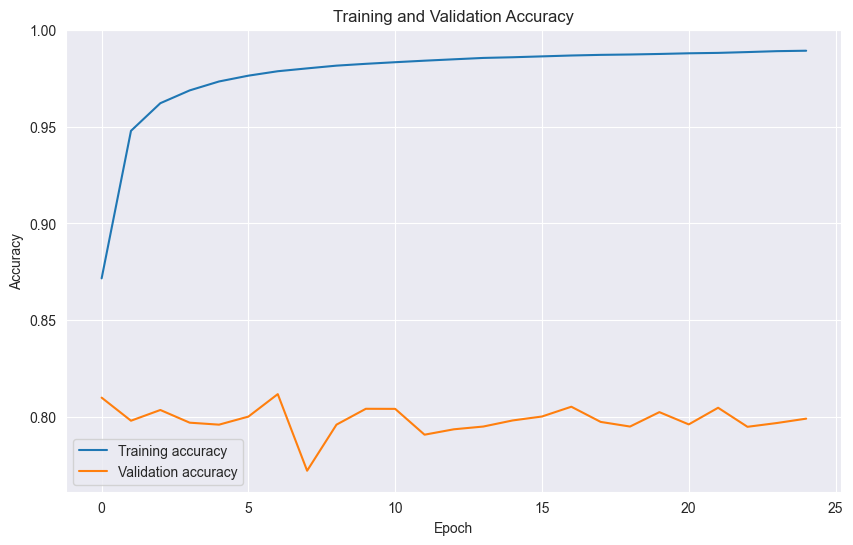

In [5]:
from tensorflow.keras.optimizers import Adam

# Reshape the data for 1D convolutional network
x_train = FINAL_TRAIN.reshape(FINAL_TRAIN.shape[0], FINAL_TRAIN.shape[1], 1)
x_test = FINAL_TEST.reshape(FINAL_TEST.shape[0], FINAL_TEST.shape[1], 1)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, labels_train)).shuffle(len(x_train)).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, labels_test)).batch(256)

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(23, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00025),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=25, validation_data=test_dataset)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
from itertools import cycle

# 预测测试集
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# 真实标签
y_true = y_test

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 计算并打印召回率、准确率和F1分数
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

# 计算ROC曲线和AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# ... (其他评估指标的代码)
